# Sentiment Analysis Of Donald Trump's Tweets from 2019 

### Out-of-Core Learning Implementation

Authors: Tiffany J Munn (tiffany.munn@du.edu)* and Tai Chen Ye (tai-chen.ye@du.edu)*

*University of Denver: Department of Computer Science and Engineering

Last Update: August 27th, 2020

Note:
Many functions used in the code below were repurposed from:
https://github.com/rasbt/python-machine-learning-book-3rd-edition Copyright (c) 2019 Sebastian Raschka

## PART 1 - Experiment Objective


Sentiment analysis uses natural language processing to analyze affective states and subjective information. In recent years considerable concern has arisen over the Sentiment analysis of a political issue.For example,  Josemar A. Caetano uses sentiment analysis to define twitter political users’ classes and their homophily during the 2016 American presidential election. Also,  Haselmayer use the sentiment analysis in political communication topic. A number of studies have been conducted on political issues in using Sentiment analysis. 

While others have done sentiment analysis on the tweets of our current president, Donald Trump, a more difficult task than just predicting positive or negative tweets, is capturing a 'neutral' sentiment as well. That is our aim here. We expect that capturing neurtral sentiments for Trump will be difficult as many of his tweets seem neutral but are embedded with back-handed comments that tend to lean negative. Thus, we expect that our model will need feedback to improve and therefore is a great choice for a project with a database that allows feedback from users and then partial fits to the model with that feeback.

Hence, in this project we collect Donald J. Trump's tweets from http://www.trumptwitterarchive.com/ as text. Since the data is unlabeled, first, we analyze Donald Trump 2019's tweets to determine sentiment labels with TextBlob and then build a model to predict sentiment for tweets not in our training set.

#### TOS and Ethical Considerations

The website mentioned above is an open-source website that pulls from Twitter itself, where of course, Tweets are publicly available. Therefore, there should be no ethical concerns with using this data.

To be sure, under FAQs of the website we see this question:

    "Can I use your data?"
    "Yes. You can find the Trump data here (updated hourly). You can find the other accounts here (updated infrequently). 
    Let me know if you create anything cool."

## PART 2 - Data Collection

#### Importing Relevant Packages

In [30]:
from IPython.display import Image
import pandas as pd
import re
from textblob import TextBlob
import nltk
import numpy as np
import sklearn
import flask
import pickle
import os
import shutil 
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Read in a classifiable training dataset from the Internet using Python for sentiment analysis.
we collect the data from webstie http://www.trumptwitterarchive.com/ .Here we downloading an archive.


In [31]:
os.chdir('/home/jovyan/projects/Project02')
data_2019= pd.read_excel('2019.xlsx',sep=',', encoding='utf-8')  

### Data Labeling

Like most internet data, this data did not come to us labeled. Therefore, we utilized a library called TextBlob, that provides a sentiment and polarity value for each text. We apply this to our data to create our label. We then transform those values to create our 3 labels "positive", "negative", and "neutral".

#### Use TextBlob to Create Sentiment values for Each Tweet

In [32]:
data_2019['label']=data_2019.apply(lambda x: TextBlob(x.to_string()).sentiment.polarity, axis=1)

print(data_2019)

                                                   text     label
0     Our prayers are with the families of the victi...  0.000000
1          RT @realDonaldTrump: https://t.co/Mn4EJ7Jbh8  0.000000
2     RT @BreitbartNews: This Christmas let the impe...  0.000000
3     He is Fake News will always be Fredo to us. I ... -0.500000
4     Thank you to highly respected Jewish leader Do...  0.080000
...                                                 ...       ...
7776  RT @GOPChairwoman: Jobless claims fell last we...  0.000000
7777  The Democrats much as I suspected have allocat...  0.200000
7778                                    Happy New Year!  0.485227
7779  HAPPY NEW YEAR TO EVERYONE INCLUDING THE HATER...  0.468182
7780  Dr. Sebastian Gorka a very good and talented g...  0.805000

[7781 rows x 2 columns]


#### Convert sentiment values to labeled:  2 is positive, 0 is negative, 1 is neutral.

In [33]:
def convert(x):    
    if x>0:
        return 2
    elif x<0:
        return 0
    else:    
        return 1

data_2019['label']=data_2019['label'].apply(convert)
print(data_2019)

                                                   text  label
0     Our prayers are with the families of the victi...      1
1          RT @realDonaldTrump: https://t.co/Mn4EJ7Jbh8      1
2     RT @BreitbartNews: This Christmas let the impe...      1
3     He is Fake News will always be Fredo to us. I ...      0
4     Thank you to highly respected Jewish leader Do...      2
...                                                 ...    ...
7776  RT @GOPChairwoman: Jobless claims fell last we...      1
7777  The Democrats much as I suspected have allocat...      2
7778                                    Happy New Year!      2
7779  HAPPY NEW YEAR TO EVERYONE INCLUDING THE HATER...      2
7780  Dr. Sebastian Gorka a very good and talented g...      2

[7781 rows x 2 columns]


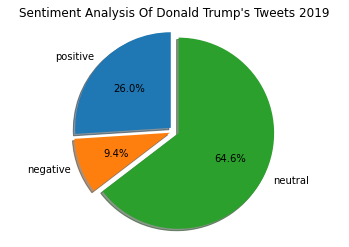

In [34]:
import matplotlib.pyplot as plt
labels = 'positive', 'negative', 'neutral'

neg_count=len(data_2019.loc[data_2019['label'] == 0])
neu_count=len(data_2019.loc[data_2019['label'] == 1])
post_count=len(data_2019.loc[data_2019['label'] == 2])

sizes = [post_count, neg_count, neu_count ]
explode = (0.05, 0.05, 0.05)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.title("Sentiment Analysis Of Donald Trump's Tweets 2019")
plt.show()


## PART 3 - Data Preprocessing


#### Clean text data, Tokenize the document, and construct Relevant Vectorizer Files

#### Creating Tfidf Vectorizer to use to Train our Data

In [35]:
%%writefile tf_vectorizer.py
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import os
import pickle
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer


stop = stopwords.words('english')
porter = PorterStemmer()

#  clean my text data, tokenize the document
def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    text = re.sub(r'\d+', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) \
                   + ' '.join(emoticons).replace('-', '')
    tokenized = [porter.stem(w) for w in text.split() if w not in stop]
    return tokenized
            
            
# construct a TfidfVectorizer

vect = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None,tokenizer=tokenizer)


Overwriting tf_vectorizer.py


#### Create a Hashing Vectorizer to be used for Out-of-Core Learning

In [36]:
#creating our tweetclassifier directory to put these files in

if not os.path.exists('/home/jovyan/projects/Project02/tweetclassifier'):
    os.makedirs('/home/jovyan/projects/Project02/tweetclassifier')

In [37]:
%%writefile tweetclassifier/hash_vectorizer.py
from sklearn.feature_extraction.text import HashingVectorizer
import re
import os
import pickle
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

stop = stopwords.words('english')

porter = PorterStemmer()

#  clean my text data, tokenize the document
def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    text = re.sub(r'\d+', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) \
                   + ' '.join(emoticons).replace('-', '')
    tokenized = [porter.stem(w) for w in text.split() if w not in stop]
    return tokenized
            
# construct a Hashing Vectorizer

vect = HashingVectorizer(decode_error='ignore',
                         n_features=2**21,
                         preprocessor=None,
                         tokenizer=tokenizer)

Overwriting tweetclassifier/hash_vectorizer.py


In [38]:
#make a copy of this for our website for later

if not os.path.exists('/home/jovyan/projects/Project02/website'):
    os.makedirs('/home/jovyan/projects/Project02/website')

shutil.copy2('/home/jovyan/projects/Project02/tweetclassifier/hash_vectorizer.py',\
             '/home/jovyan/projects/Project02/website/hash_vectorizer.py')


'/home/jovyan/projects/Project02/website/hash_vectorizer.py'

## PART 4 - Model Optimization and Serialization


### Perform a Grid Search to Get Best Params for an SGD Model

In [42]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from tf_vectorizer import vect

#splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(data_2019['text'], data_2019['label'], test_size=0.3, random_state=1)

#applying the Tfidf Vectorizer
X_train, X_test =vect.fit_transform(X_train),vect.fit_transform(X_test)


params = {"loss" : ["log"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "none"]}

gs = GridSearchCV(estimator=SGDClassifier(max_iter=100000, random_state=1),
                  param_grid=params,
                  scoring='accuracy',
                  cv=5)

gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=100000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5, random_state=1,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1], 'loss': ['log'],
                         'penalty': ['l2', 'l1', 'none']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=Fal

### Apply the optimized parameters to the HashingVectorizer For out-of-core learning file

In [43]:
print(f'Best params from grid: {gs.best_params_}')
clf = gs.best_estimator_


Best params from grid: {'alpha': 0.0001, 'loss': 'log', 'penalty': 'l1'}


In [51]:
os.chdir('/home/jovyan/projects/Project02/website')

from hash_vectorizer import vect

#applying the Hashing Vectorizer
#splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(data_2019['text'], data_2019['label'], test_size=0.3, random_state=1)

X_train, X_test =vect.transform(X_train),vect.transform(X_test)

clf = SGDClassifier(loss='log', penalty='l1',alpha=0.0001, max_iter=100000, random_state=1)

clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log',
              max_iter=100000, n_iter_no_change=5, n_jobs=None, penalty='l1',
              power_t=0.5, random_state=1, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

### computed accuracies against  training and test datasets

In [52]:
print('Accuracy of trainning data', clf.score(X_train, y_train))

Accuracy of trainning data 0.7627616599338964


In [53]:
print('Accuracy of test data', clf.score(X_test, y_test))

Accuracy of test data 0.7323340471092077


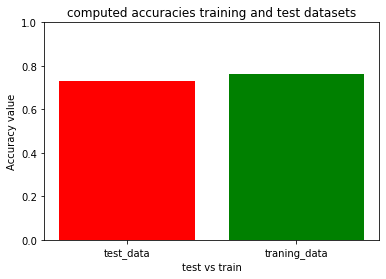

In [54]:
data=[0.73233,0.76276]
label=['test_data','traning_data']

axes = plt.gca()
axes.set_ylim([0,1])

plt.bar(label, data, color=('red', 'green'))
plt.xlabel("test vs train")
plt.ylabel("Accuracy value")
plt.title("computed accuracies training and test datasets")
plt.show()

### Pickle the resulting objects to a file 

In [55]:
clf = clf.partial_fit(X_test, y_test)

In [56]:
#pickling for our current version
import pickle
import os
from nltk.corpus import stopwords

stop = stopwords.words('english')
dest = os.path.join('tweetclassifier', 'pkl_objects')
if not os.path.exists(dest):
    os.makedirs(dest)

pickle.dump(stop, open(os.path.join(dest, 'stopwords.pkl'), 'wb'), protocol=4)   
pickle.dump(clf, open(os.path.join(dest, 'classifier.pkl'), 'wb'), protocol=4)


In [62]:
#pickling for our out-of-core learning version
import pickle
import os

dest = os.path.join('website', 'pkl_objects')
if not os.path.exists(dest):
    os.makedirs(dest)

pickle.dump(stop, open(os.path.join(dest, 'stopwords.pkl'), 'wb'), protocol=4)   
pickle.dump(clf, open(os.path.join(dest, 'classifier.pkl'), 'wb'), protocol=4)

### Testing to See if our Pickling Worked

In [60]:
os.chdir('/home/jovyan/projects/Project02/website')

In [65]:
import pickle
import re
import os

clf = pickle.load(open(os.path.join('pkl_objects', 'classifier.pkl'), 'rb'))

In [66]:
import numpy as np
label = {0:'negative', 1:'neutral',2:'positive'}

example = ["This world is fantastic."]

X = vect.transform(example)

print('Prediction: %s\nProbability: %.2f%%' %\
      (label[clf.predict(X)[0]], 
       np.max(clf.predict_proba(X))*100))

Prediction: positive
Probability: 68.17%


## PART 5 - Website Creation and Publishing

In [155]:
os.chdir('/home/jovyan/projects/Project02/tweetclassifier')

os.getcwd()

'/home/jovyan/projects/Project02/tweetclassifier'

In [159]:
import shutil

os.chdir('..')

if not os.path.exists('tweetclassifier_with_update'):
    os.mkdir('tweetclassifier_with_update')
os.chdir('tweetclassifier_with_update')

if not os.path.exists('pkl_objects'):
    os.mkdir('pkl_objects')

shutil.copyfile('../tweetclassifier/pkl_objects/classifier.pkl',
                './pkl_objects/classifier.pkl')

shutil.copyfile('../tweetclassifier/tweets.sqlite',
                './tweets.sqlite')

'./tweets.sqlite'

### Our Website hosting this classifier located here: http://overrunmunn.pythonanywhere.com/
